# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from scipy.stats import norm
from operator import itemgetter

from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

GENERAL_DEMOGRAPHICS = "Udacity_AZDIAS_Subset.csv"
CUSTOMERS_SUBSET = "Udacity_CUSTOMERS_Subset.csv"
FEATURE_SUMMARY = "AZDIAS_Feature_Summary.csv"

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv(GENERAL_DEMOGRAPHICS, sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv(FEATURE_SUMMARY, sep=';')

azdias.head(n=10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [3]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ARBEIT,person,ordinal,[-1]
freq,1,43,49,26


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for column_name, missing_values in list(zip(feat_info['attribute'], feat_info['missing_or_unknown'])):
    try:
        missing_or_unknown_values = literal_eval(missing_values)
    except Exception as e:
        # non integers in value
        missing_or_unknown_values = missing_values.strip()[1:-1].split(',')
    replace_dict = dict(zip(missing_or_unknown_values, [np.nan] * len(missing_or_unknown_values)))
    azdias.loc[:, column_name].replace(replace_dict, inplace=True)
azdias.head(n=10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_data = azdias.isnull().sum()
non_null_data = azdias.notnull().sum()

In [12]:
azdias.shape

(891221, 85)

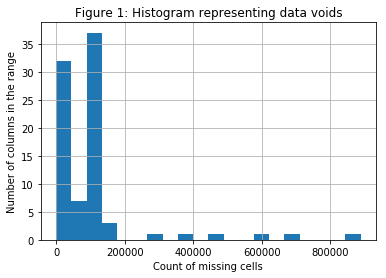

In [13]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(missing_data, bins=20, alpha=1)
plt.xlabel('Count of missing cells')
plt.ylabel('Number of columns in the range')
plt.title('Figure 1: Histogram representing data voids')
plt.grid(True)
plt.show()

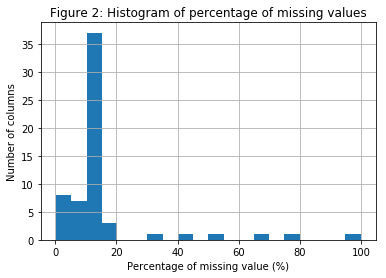

In [14]:
plt.hist(((missing_data[missing_data >= 1]/(azdias.shape[0])) * 100), bins=20, alpha=1)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Number of columns')
plt.title('Figure 2: Histogram of percentage of missing values')
plt.grid(True)

Text(0.5, 1.0, 'Figure 3: Distribution of Data Density')

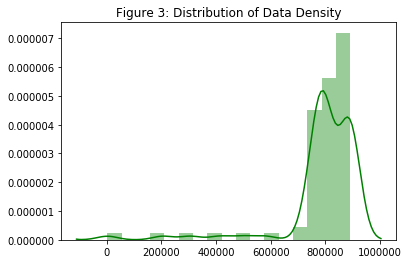

In [15]:
sns.distplot(non_null_data, hist=True, kde=True, color='g').set_title('Figure 3: Distribution of Data Density')

Text(0.5, 1.0, 'Figure 4: Distribution of Missing Data')

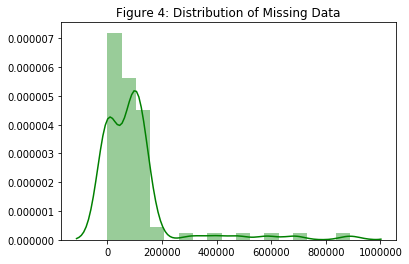

In [16]:
sns.distplot(missing_data, hist=True, kde=True, color='g').set_title('Figure 4: Distribution of Missing Data')

In [17]:
mu, std = norm.fit(missing_data)
percentile_90 = mu + (1.282 * std)

percentile_90

285354.5613083471

In [18]:
missing_data_df = pd.DataFrame(missing_data, columns=['Count'])
missing_data_df.head(n=10)

,Count
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [19]:
# Columns above the 90th percentile of missing data count

cols_to_remove = missing_data_df[missing_data_df['Count'] > percentile_90] # Above 90th percentile
cols_to_remove.sort_values('Count', ascending=False)

,Count
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318
ALTER_HH,310267


In [20]:
# Percentage of missing data contributed by these 6 columns

cols_to_remove['Count'].sum()/missing_data_df['Count'].sum()

0.39869277611501125

**Comment:**

From Figure 4, it is clear that the density of data is too low for the 6 columns with most null values.
The above 6 columns have more than 200000 rows missing data. We shall remove them from the dataframe

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
    
azdias.drop(cols_to_remove.index, axis=1, inplace=True)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [22]:
missing_feature_percent = (missing_data[missing_data > 0]/azdias.shape[0]).sort_values()
missing_feature_percent

ALTERSKATEGORIE_GROB     0.003233
CJT_GESAMTTYP            0.005446
GFK_URLAUBERTYP          0.005446
ONLINE_AFFINITAET        0.005446
RETOURTYP_BK_S           0.005446
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
HH_EINKOMMEN_SCORE       0.020587
ANZ_PERSONEN             0.082470
SOHO_KZ                  0.082470
ANZ_TITEL                0.082470
WOHNDAUER_2008           0.082470
KONSUMNAEHE              0.082997
LP_FAMILIE_GROB          0.087287
LP_FAMILIE_FEIN          0.087287
GEBAEUDETYP              0.104517
WOHNLAGE                 0.104517
OST_WEST_KZ              0.104517
MIN_GEBAEUDEJAHR         0.104517
GEBAEUDETYP_RASTER       0.104525
EWDICHTE                 0.105182
BALLRAUM                 0.105182
INNENSTADT               0.105182
LP_LEBENSPHASE_GROB      0.106115
ANZ_HH_TITEL             0.108848
ORTSGR_KLS9              0.109147
ARBEIT                   0.109260
RELAT_AB                 0.109260
LP_LEBENSPHASE_FEIN      0.109549
CAMEO_DEUG_201

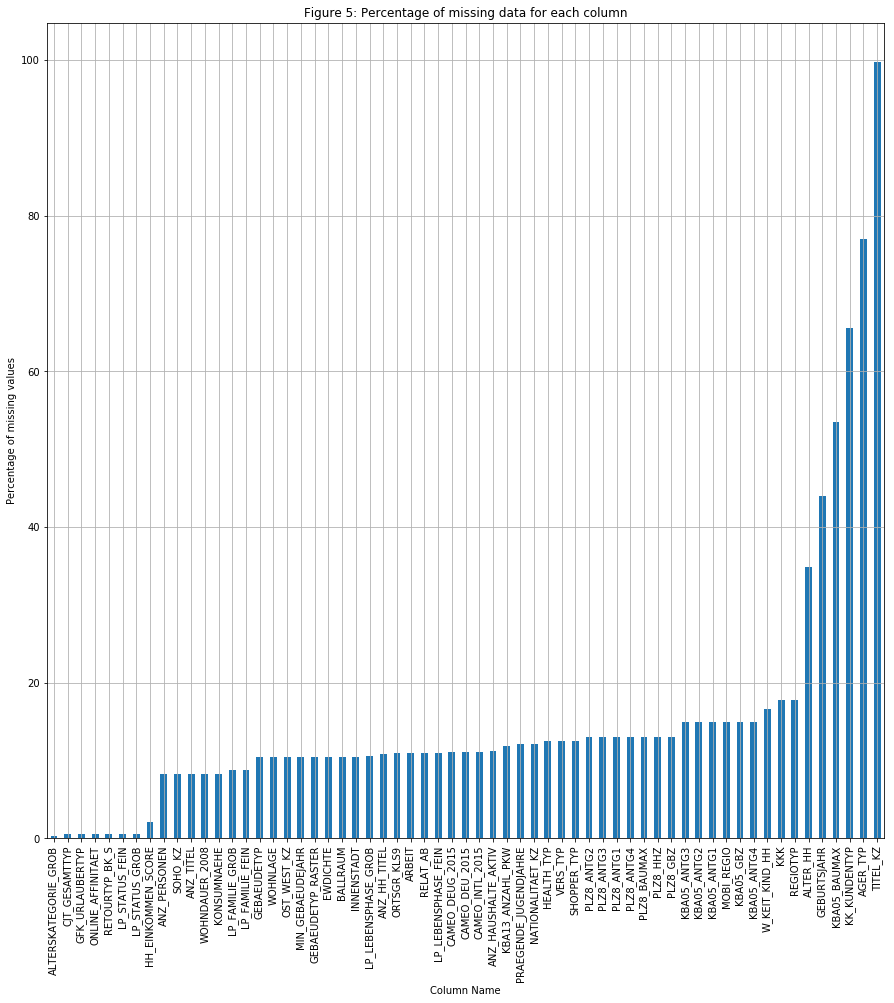

Total columns with missing values: 61


In [23]:
missing_columns = missing_data[missing_data > 0]/azdias.shape[0] * 100
missing_columns.sort_values(inplace=True)
missing_columns.plot.bar(figsize=(15,15))
plt.xlabel('Column Name')
plt.ylabel('Percentage of missing values')
plt.grid(True)
plt.title('Figure 5: Percentage of missing data for each column')
plt.show()
print("Total columns with missing values: {}".format(len(missing_columns)))

In [24]:
(missing_data/missing_data.sum()).sort_values(ascending=False)

TITEL_KZ                 0.106170
AGER_TYP                 0.081902
KK_KUNDENTYP             0.069813
KBA05_BAUMAX             0.056906
GEBURTSJAHR              0.046850
ALTER_HH                 0.037052
REGIOTYP                 0.018876
KKK                      0.018876
W_KEIT_KIND_HH           0.017672
KBA05_ANTG4              0.015921
KBA05_GBZ                0.015921
MOBI_REGIO               0.015921
KBA05_ANTG1              0.015921
KBA05_ANTG2              0.015921
KBA05_ANTG3              0.015921
PLZ8_GBZ                 0.013914
PLZ8_HHZ                 0.013914
PLZ8_BAUMAX              0.013914
PLZ8_ANTG4               0.013914
PLZ8_ANTG1               0.013914
PLZ8_ANTG3               0.013914
PLZ8_ANTG2               0.013914
SHOPPER_TYP              0.013279
VERS_TYP                 0.013279
HEALTH_TYP               0.013279
NATIONALITAET_KZ         0.012935
PRAEGENDE_JUGENDJAHRE    0.012917
KBA13_ANZAHL_PKW         0.012634
ANZ_HAUSHALTE_AKTIV      0.011895
CAMEO_INTL_201

In [25]:
# Missing features by feature category

category_to_attributes = feat_info.groupby('information_level')['attribute'].apply(lambda x: x.values.tolist())
category_to_attributes = category_to_attributes.to_dict()
missing_feature_percent_dict = missing_feature_percent.to_dict()

group_list = []
percent_list = []
for group_name, list_of_columns in category_to_attributes.items():
    percent_sum = 0
    for col in list_of_columns:
        percent_sum += missing_feature_percent_dict.get(col, 0)
        
    group_list.append(group_name)
    percent_list.append(percent_sum/len(list_of_columns))

pd.DataFrame.from_dict({'Category': group_list, 'Percent': percent_list}).sort_values('Percent').reset_index(drop=True)

,Category,Percent
0,person,0.077389
1,building,0.103098
2,postcode,0.105182
3,community,0.109222
4,microcell_rr4,0.111479
5,region_rr1,0.122856
6,macrocell_plz8,0.129234
7,household,0.205450
8,microcell_rr3,0.213779


#### Discussion 1.1.2: Assess Missing Data in Each Column

Some important observatons

1. Number of columns with missing data = 61 (Figure 5)
2. Column with maximum percentage of missing data = TITEL_KZ (99.75%) (Figure 5)
3. Category of features which have the most missing values = microcell_rr3 and household
4. Number of columns which contribute to almost 40% of missing data = 6

61 columns contain missing data ranging from 0.034% to 10.6% of total missing data. 
The 90th percentile of missing data computes to 285354.
Figure 1 illustrates the count of columns having > 285354 rows which equates to around more than 39% of all the missing values in the dataset. 
Figure 3 illustrates the percentage distribution of count of missing values, where 7 columns have 0.5% of missing values.
Figure 5 illustrates the percentage contribution of each column in missing data. It can be clearly observed that 6 columns contribute to most of the missing data (39%).

These columns are  'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'.
Imputation of missing values of these columns may introduce a bias and it is better to drop these column altogether.

After removing these 6 columns, the **number of features have come down to 79**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
print(sum(azdias.isnull().any(axis=1)))

268012


Total of 268012 rows contains 1 or more missing values out of 891221 observations. That means 30% of our observations (rows) have any sort of missing values.

In [27]:
azdias['Missing'] = azdias.apply(lambda x: 79 - x.count(), axis=1)
azdias.head(n=10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Missing
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


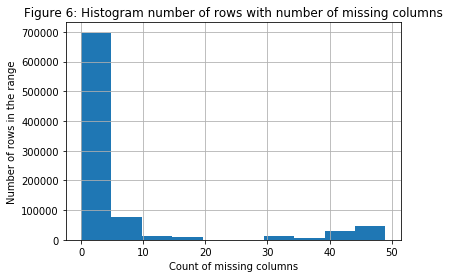

In [28]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(azdias['Missing'], bins=10, alpha=1)
plt.xlabel('Count of missing columns')
plt.ylabel('Number of rows in the range')
plt.title('Figure 6: Histogram number of rows with number of missing columns')
plt.grid(True)
plt.show()

**Observation**

Just like the missing column analysis, the rows data can be split into two parts by observing the above plot.
number of columns = 25 seems like a good number to split the rows into two.

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

n_missing = azdias.isnull().transpose().sum()
azdias_missing_low = azdias[n_missing < 25]
azdias_missing_high = azdias[n_missing >= 25];
n_missing_low = azdias_missing_low.isnull().transpose().sum()
n_missing_high = azdias_missing_high.isnull().transpose().sum()

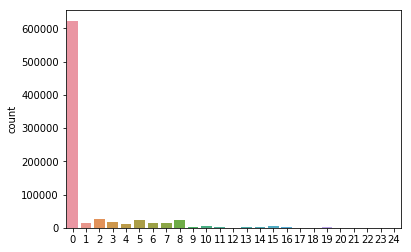

In [30]:
sns.countplot(azdias_missing_low.isnull().transpose().sum())

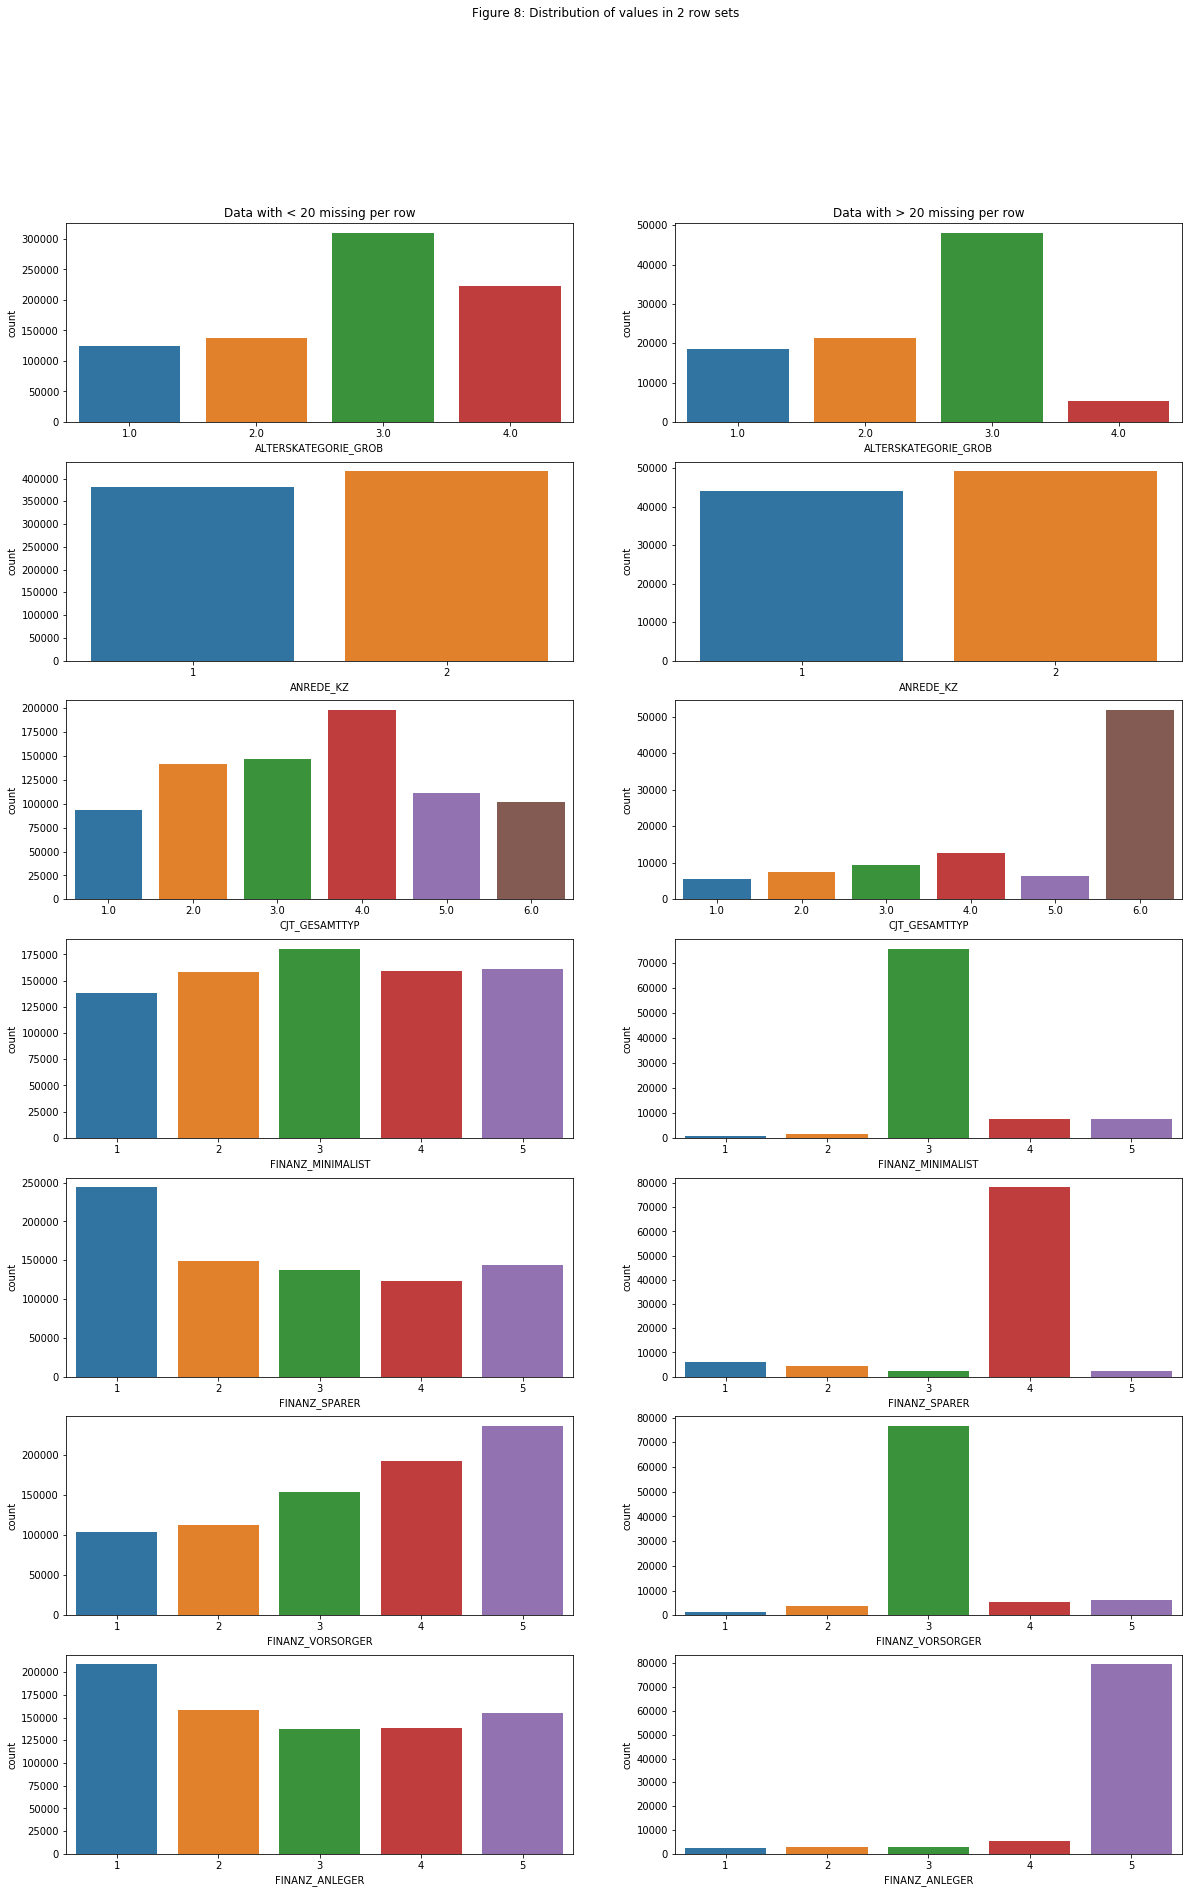

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,30))
fig.suptitle('Figure 8: Distribution of values in 2 row sets')
n=0
for column in azdias.columns[0:7]:
    sns.countplot(azdias_missing_low.loc[:, column], ax=axes[n,0])
    if n == 0:
        axes[n,0].set_title('Data with < 20 missing per row')
    sns.countplot(azdias_missing_high.loc[:, column], ax=axes[n,1])
    if n == 0:
        axes[n,1].set_title('Data with > 20 missing per row')
    n += 1

In [32]:
azdias_missing_low.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Missing
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0


In [33]:
total_missing = azdias[azdias['Missing'] > 0]
total_missing_percent = total_missing.shape[0]/azdias.shape[0]
total_missing_percent

0.3007245116531141

In [34]:
azdias_missing_high.shape[0]/total_missing.shape[0]


0.34817470859513755

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Observations**

When comparing the results of total number of rows containing 1 or more missing values with total number of total observations (rows) we find that around 30% of data has 1 or more missing values. Around 93315 rows out of 891221 i.e. around 10.4% contain more than 30% ((25/79)x100) missing values in each row.

Options to manage with missing values:

1) Drop all the columns that have missing values which means 55 columns being dropped after dropping {'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'}initially as referred from Figure 2 leaving us with only 24 columns out of 79 columns.

2) Drop all rows that contain all missing values which means dropping 30% of our data.

3) Trying to impute the missing values in rows with the mode since mode is least affected by outliers in contrast to mean or median.

From Figure 8 above, we can make two observations:

1. There are columns with similar distributions. For Example, ANREDE_KZ.
2. There are also columns with different distributions across the two row sets.

Skipping the rows with different distributions will definitely affect the analysis because the data in these two rowsets are qualitatively different.

However, as directed, we will proceed with only few/no-missing-values rows and revisit this more-missing rows later.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?

feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical = [x for x in categorical if x in azdias.columns] # only the ones that are kept in azdias dataset
binary = [x for x in categorical if azdias[x].nunique() == 2]
multilevel = [x for x in categorical if azdias[x].nunique() > 2]
azdias[categorical].nunique(), binary, multilevel

(ANREDE_KZ            2
 CJT_GESAMTTYP        6
 FINANZTYP            6
 GFK_URLAUBERTYP     12
 GREEN_AVANTGARDE     2
 LP_FAMILIE_FEIN     11
 LP_FAMILIE_GROB      5
 LP_STATUS_FEIN      10
 LP_STATUS_GROB       5
 NATIONALITAET_KZ     3
 SHOPPER_TYP          4
 SOHO_KZ              2
 VERS_TYP             2
 ZABEOTYP             6
 GEBAEUDETYP          7
 OST_WEST_KZ          2
 CAMEO_DEUG_2015      9
 CAMEO_DEU_2015      44
 dtype: int64,
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'],
 ['CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015'])

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Removing multilevel categorical variables with too many values
multilevel.remove('CAMEO_DEU_2015')
azdias_missing_low.drop('CAMEO_DEU_2015', axis=1, inplace=True)

# Converting binary variable with non-numeric values into a binary variable with numeric values

azdias_missing_low.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

# encoding multilevel features with dummies

for col in multilevel:
    dat = azdias_missing_low[col][azdias_missing_low[col].notnull()]
    dummies = pd.get_dummies(dat, prefix=col)
    azdias_missing_low = azdias_missing_low.join(dummies)
    azdias_missing_low.drop([col], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [38]:
azdias_missing_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Columns: 151 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(107), int64(24), object(1), uint8(19)
memory usage: 844.1+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

1. Among the multilevel categorical features, 'CAMEO_DEU_2015' was removed since 44 differrent levels of this features will result in 44 dummy variables which is not much of use. 

2. 'OST_WEST_KZ' is converted into a numeric binary feature replacing 'W' with 0 and 'O' with 1. 

3. For all multi-level caegorical variable, we did one-hot encoding or dummy variables (n-1 features) using pd.get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed = [x for x in mixed if x in azdias_missing_low.columns] # only the ones that are kept in azdias_lowmiss dataset

# Extract variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
def mstream(x):
    if x in mainstream:
        return 1
    elif x in avantgarde:
        return 0
    else:
        return x

azdias_missing_low['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

# Create variable mapping 'decade' and map it to PRAEGENDE_JUGENDJAHRE, creating a new binary feature
x = [x+1 for x in range(15)]
y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
decade = pd.Series(y, index = x)
azdias_missing_low['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].map(decade)

In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

In [41]:
azdias_missing_low.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
azdias_missing_low.drop('CAMEO_INTL_2015', axis=1, inplace=True)
azdias_missing_low.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [42]:
mixed.remove('LP_LEBENSPHASE_FEIN')
mixed.remove('PRAEGENDE_JUGENDJAHRE')
mixed.remove('CAMEO_INTL_2015')

mixed

['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [43]:
for col in mixed:
    dat = azdias_missing_low[col][azdias_missing_low[col].notnull()]
    dummies = pd.get_dummies(dat, prefix=col)
    azdias_missing_low = azdias_missing_low.join(dummies)
    azdias_missing_low.drop([col], axis=1, inplace=True)
    
azdias_missing_low.head(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into two features each. 
2. LP_LEBENSPHASE_FINE was removed from the data due to the high number of levels. LP_LEBENSPHASE_GROB contains an approximate information of the same and should suffice.
3. One hot encoding was applied to all other mixed variables

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

list(azdias_missing_low.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'Missing',
 '

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Removing columns used for storing missing columns
azdias_missing_low.drop('Missing', axis=1, inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [65]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for column_name, missing_values in list(zip(feat_info['attribute'], feat_info['missing_or_unknown'])):
        try:
            missing_or_unknown_values = literal_eval(missing_values)
        except Exception as e:
            # non integers in value
            missing_or_unknown_values = missing_values.strip()[1:-1].split(',')
        replace_dict = dict(zip(missing_or_unknown_values, [np.nan] * len(missing_or_unknown_values)))
        df.loc[:, column_name].replace(replace_dict, inplace=True)

    
    # remove selected columns and rows, ...
    missing_data = df.isnull().sum()
    missing_data_df = pd.DataFrame(missing_data, columns=['Count'])
    mu, std = norm.fit(missing_data)
    percentile_90 = mu + (1.282 * std)
    cols_to_remove = missing_data_df[missing_data_df['Count'] > percentile_90] # Above 90th percentile
    df.drop(cols_to_remove.index, axis=1, inplace=True)
    
    n_missing = df.isnull().transpose().sum()
    df_lowmiss = df[n_missing < 25]
    # select, re-encode, and engineer column values.

    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical = [x for x in categorical if x in df_lowmiss.columns] # only the ones that are kept in df dataset
    binary = [x for x in categorical if df_lowmiss[x].nunique()==2]
    multilevel = [x for x in categorical if df_lowmiss[x].nunique()>2]
    
    multilevel.remove('CAMEO_DEU_2015')
    df_lowmiss.drop('CAMEO_DEU_2015', axis=1, inplace=True) # Drop CAMEO_DEU_2015 due to too much detail
    
    df_lowmiss.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True); # Convert OST_WEST_KZ into binary categorical
    
         #onehotencode multilevel
    for col in multilevel:
        dat = df_lowmiss[col][df_lowmiss[col].notnull()]
        dummies = pd.get_dummies(dat, prefix=col)
        df_lowmiss = df_lowmiss.join(dummies)
        df_lowmiss.drop([col], axis=1, inplace=True)
    
        # Extract variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    df_lowmiss['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

    # Create variable mapping 'decade' and map it to PRAEGENDE_JUGENDJAHRE, creating a new feature
    x = [x+1 for x in range(15)]
    y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    decade = pd.Series(y, index = x)
    df_lowmiss['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

    # Remove all mixed columns and LP_LEBENSPHASE_FINE which I found to be too granular to work with (40 different values)
    df_lowmiss.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df_lowmiss.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    df_lowmiss.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

    # Drop mixed columns
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df_lowmiss.columns]

    for col in mixed:
        dat = df_lowmiss[col][df_lowmiss[col].notnull()]
        dummies = pd.get_dummies(dat, prefix=col)
        df_lowmiss = df_lowmiss.join(dummies)
        df_lowmiss.drop([col], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_lowmiss
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer()
azdias_missing_low = pd.DataFrame(imputer.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

print(azdias_missing_low.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(797906, 173)


In [48]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_missing_low = pd.DataFrame(scaler.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

### Discussion 2.1: Apply Feature Scaling

1. Missing values are imputed by using Imputer.
2. Standard scaling is done for all features using StandardScaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_missing_low)

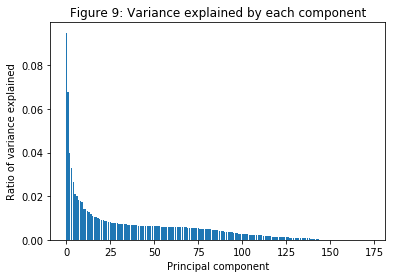

In [50]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Figure 9: Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

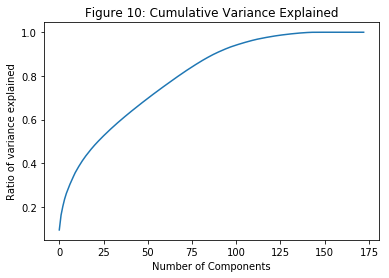

In [51]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Figure 10: Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Choosing n_components as 75 to achieve > 80% variance

pca_75 = PCA(n_components=75)

azdias_pca = pca_75.fit_transform(azdias_missing_low)

In [53]:
# percentage of variance for above chosen n_components

pca.explained_variance_ratio_.sum()

1.0000000000000002

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

By looking at Figure 10, in order to achieve > 80%, the n_components to be chosen should be at least 75. The feature set has gotten reduced by more than 55%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_missing_low.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [55]:
pca_weight_0 = pca_weights(pca_75, 0)
print (pca_weight_0)

LP_STATUS_GROB_1.0                  0.189561
PLZ8_ANTG3                          0.180698
HH_EINKOMMEN_SCORE                  0.177147
PLZ8_ANTG4                          0.174857
CAMEO_INTL_2015_WEALTH              0.174139
ORTSGR_KLS9                         0.156031
EWDICHTE                            0.154013
FINANZ_HAUSBAUER                    0.146174
LP_STATUS_FEIN_1.0                  0.126442
PLZ8_ANTG2                          0.124943
KBA05_ANTG4                         0.122955
ARBEIT                              0.112212
ANZ_HAUSHALTE_AKTIV                 0.111520
KBA05_ANTG3                         0.111419
PLZ8_BAUMAX_5.0                     0.111054
LP_STATUS_FEIN_2.0                  0.107716
LP_LEBENSPHASE_GROB_1.0             0.107344
CAMEO_DEUG_2015_9                   0.106819
RELAT_AB                            0.106263
FINANZTYP_1                         0.104738
FINANZ_SPARER                       0.103868
PRAEGENDE_JUGENDJAHRE_MAINSTREAM    0.094391
LP_FAMILIE

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_1 = pca_weights(pca_75, 1)
print (pca_weight_1)

ALTERSKATEGORIE_GROB            0.228675
FINANZ_VORSORGER                0.217992
ZABEOTYP_3                      0.194756
SEMIO_ERL                       0.172435
SEMIO_LUST                      0.159759
RETOURTYP_BK_S                  0.154225
LP_LEBENSPHASE_GROB_2.0         0.147415
W_KEIT_KIND_HH                  0.124781
CJT_GESAMTTYP_2.0               0.105796
FINANZTYP_5                     0.097482
FINANZ_MINIMALIST               0.095519
FINANZTYP_2                     0.091053
LP_STATUS_FEIN_1.0              0.090132
FINANZ_HAUSBAUER                0.076670
CJT_GESAMTTYP_1.0               0.069150
SHOPPER_TYP_3.0                 0.068504
FINANZTYP_6                     0.067939
NATIONALITAET_KZ_1.0            0.067720
SEMIO_KRIT                      0.065963
LP_FAMILIE_GROB_1.0             0.062003
LP_FAMILIE_FEIN_1.0             0.062003
EWDICHTE                        0.057387
PLZ8_ANTG3                      0.057277
GFK_URLAUBERTYP_4.0             0.056742
ORTSGR_KLS9     

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2= pca_weights(pca_75, 2)
print (pca_weight_2)

SEMIO_VERT                          0.313786
SEMIO_FAM                           0.259207
SEMIO_SOZ                           0.254206
SEMIO_KULT                          0.251875
FINANZTYP_5                         0.131759
FINANZ_MINIMALIST                   0.130448
ZABEOTYP_1                          0.121747
SHOPPER_TYP_0.0                     0.118935
SEMIO_REL                           0.117864
SEMIO_MAT                           0.091070
GREEN_AVANTGARDE                    0.086410
ORTSGR_KLS9                         0.069295
RETOURTYP_BK_S                      0.069016
EWDICHTE                            0.068258
LP_STATUS_FEIN_10.0                 0.063961
LP_STATUS_GROB_5.0                  0.063961
W_KEIT_KIND_HH                      0.060227
PLZ8_ANTG4                          0.050027
SHOPPER_TYP_1.0                     0.049628
PLZ8_ANTG3                          0.049583
ZABEOTYP_6                          0.046269
PLZ8_BAUMAX_5.0                     0.044518
LP_STATUS_

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Interpretations**

_Component 0:_ Low income and poor households with large neighbourhood and a dense community. Densely packed low income urban neighbourhoods.
1. Low Income
2. Neighbourhood of 6-10 or more
3. Poor
4. High household density

_Component 1_: Old middle class population who carefully spend and live alone.

1. Old age
2. Middle Class
3. Frugal
4. Low income
5. Living alone or in very small families

_Component 2_: Dreamy and purposeful Male
1. Male
2. Dreamful
3. Investor
4. Minimalist

**Correlations**

1. As expected PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation. If the model favours large blocks of people settlements, it doesn't restrict on the threshold.
2. ALTERSKATEGORIE_GROB and PRAEGENDE_JUGENDJAHRE_DECADE have a negative correlation, i.e., older people had spent their youth in the past.
3. PLZ8_ANTG3 and CAMEO_INTL_2015_WEALTH have a positive correlation. As size of the family increases, the household gets poorer

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [59]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
scores = []
ks = list(range(1,20))
for k in ks:
    print("Starting cluster: %s" % k)
    score = k_mean_score(azdias_pca, k)
    scores.append(score)
    print("Cluster: %s Score: %s" % (k, score))

Starting cluster: 1
Cluster: 1 Score: 115054474.9676964
Starting cluster: 2
Cluster: 2 Score: 104949390.61084634
Starting cluster: 3
Cluster: 3 Score: 100024954.68973802
Starting cluster: 4
Cluster: 4 Score: 96791524.2935728
Starting cluster: 5
Cluster: 5 Score: 94397755.73503247
Starting cluster: 6
Cluster: 6 Score: 92269067.51283117
Starting cluster: 7
Cluster: 7 Score: 90321029.17388143
Starting cluster: 8
Cluster: 8 Score: 89533931.5076208
Starting cluster: 9
Cluster: 9 Score: 87758896.42885134
Starting cluster: 10
Cluster: 10 Score: 87053534.1221636
Starting cluster: 11
Cluster: 11 Score: 85454179.09792523
Starting cluster: 12
Cluster: 12 Score: 84242026.35158509
Starting cluster: 13
Cluster: 13 Score: 83073825.43284282
Starting cluster: 14
Cluster: 14 Score: 82179993.06501167
Starting cluster: 15
Cluster: 15 Score: 81318037.09065753
Starting cluster: 16
Cluster: 16 Score: 80402856.68688588
Starting cluster: 17
Cluster: 17 Score: 79565913.89225166
Starting cluster: 18
Cluster: 18 

Text(0, 0.5, 'SSE')

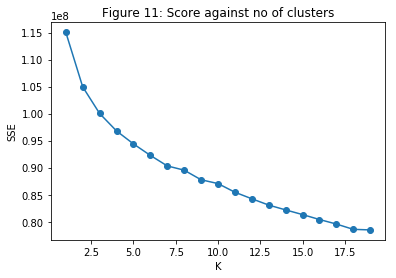

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(ks, scores, linestyle='-', marker='o')
plt.title('Figure 11: Score against no of clusters')
plt.xlabel('K')
plt.ylabel('SSE')

In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
model = kmeans.fit(azdias_pca)
azdias_pred = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

From Figure 11, it is clear that elbow occurs when k=18. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [98]:
# Load in the customer demographics data.
customers = pd.read_csv(CUSTOMERS_SUBSET, sep=';')

In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [100]:
fill_missing = Imputer()
customers_clean_imputed = pd.DataFrame(fill_missing.fit_transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [101]:
# Apply scaler
customers_clean_scaled = scaler.transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))
# PCA transformation
customers_pca = pca_75.transform(customers_clean_scaled)

In [102]:
# Cluster

customers_pred = model.predict(customers_pca)

In [103]:
np.unique(customers_pred)

array([6, 7, 8, 9], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General Clusters')

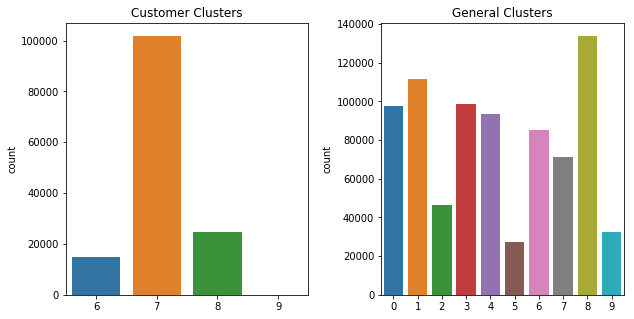

In [104]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_7 = scaler.inverse_transform(pca_75.inverse_transform(model.cluster_centers_[7]))
overrepresented_c = pd.Series(data = centroid_7, index = customers_clean.columns)
overrepresented_c

ALTERSKATEGORIE_GROB                 3.384487
ANREDE_KZ                            1.691108
FINANZ_MINIMALIST                    3.099562
FINANZ_SPARER                        1.702431
FINANZ_VORSORGER                     4.358384
FINANZ_ANLEGER                       2.385751
FINANZ_UNAUFFAELLIGER                1.760171
FINANZ_HAUSBAUER                     3.941722
GREEN_AVANTGARDE                     0.138031
HEALTH_TYP                           2.100798
RETOURTYP_BK_S                       4.011061
SEMIO_SOZ                            3.416559
SEMIO_FAM                            3.091801
SEMIO_REL                            2.769821
SEMIO_MAT                            3.168765
SEMIO_VERT                           3.793123
SEMIO_LUST                           5.071107
SEMIO_ERL                            5.699163
SEMIO_KULT                           2.892756
SEMIO_RAT                            3.275833
SEMIO_KRIT                           5.162272
SEMIO_DOM                         

In [107]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_8 = scaler.inverse_transform(pca_75.inverse_transform(model.cluster_centers_[8]))
underrepresented_c = pd.Series(data = centroid_8, index = customers_clean.columns)
underrepresented_c

ALTERSKATEGORIE_GROB                 1.836146
ANREDE_KZ                            1.590490
FINANZ_MINIMALIST                    1.325288
FINANZ_SPARER                        4.522645
FINANZ_VORSORGER                     2.045726
FINANZ_ANLEGER                       4.076913
FINANZ_UNAUFFAELLIGER                3.902692
FINANZ_HAUSBAUER                     4.094643
GREEN_AVANTGARDE                     0.061557
HEALTH_TYP                           2.258001
RETOURTYP_BK_S                       2.553423
SEMIO_SOZ                            4.520727
SEMIO_FAM                            5.010863
SEMIO_REL                            5.663414
SEMIO_MAT                            4.824645
SEMIO_VERT                           3.731409
SEMIO_LUST                           3.196822
SEMIO_ERL                            3.568641
SEMIO_KULT                           5.125548
SEMIO_RAT                            5.199587
SEMIO_KRIT                           4.438031
SEMIO_DOM                         

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the anaylsis above, it can be seen that

Cluster 4 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

in areas where the share of 6-10 family homes is lower (PLZ8_ANTG3=1.73)
in Prosperous or Comfortable households (WEALTH=2.75)
in life stage of Families With School Age Children or Older Families & Mature Couples (LIFE_STAGE=3.30)
Cluster 13 is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

in areas where the share of 6-10 family homes is higher (PLZ8_ANTG3=2.44)
in Less Affluent or Poorer households (WEALTH=4.4)
in life stage of Pre-Family Couples & Singles or Young Couples With Children (LIFE_STAGE=1.98)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.